In [1]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [2]:
#"""此note book为股票回测框架的示例"""

In [3]:
# Libraries to use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

c:\python27\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# Import My own library for factor testing
from SingleFactorTest import factorFilterFunctions as ff
from BackTestingEngine import backTestingEngine as bte
#from config import *

In [5]:
path = ff.data_path

In [6]:
startTime =  datetime.strptime('20160504', '%Y%m%d')
endTime = datetime.strptime('20170228', '%Y%m%d')
initstartTime =  datetime.strptime('20160304', '%Y%m%d')
initendTime = datetime.strptime('20170328', '%Y%m%d')

In [7]:
filenameAdjOpen = 'OwnfactorAdjustedOpen.h5'
filenameAdjClose = 'OwnfactorAdjustedClose.h5'
filenameVolume = 'LZ_CN_STKA_QUOTE_TVOLUME.h5'

In [8]:
# 初始化
test = bte.StkBacktesting(path)

In [9]:
# 添加数据
test.addData('adjOpen',filenameAdjOpen)
test.addData('adjClose',filenameAdjClose)
test.addData('volume',filenameVolume)

In [10]:
# 截取回测区间和初始化区间
test.setBackTestingPeriod(startTime,endTime)
test.setInitialPeriod(initstartTime,initendTime)

In [11]:
# 双均线筛选买卖股
ma5 = test.dataDict['adjClose'].rolling(window=5, min_periods=5).mean()
ma20 = test.dataDict['adjClose'].rolling(window=20, min_periods=20).mean()
buyStk = ((ma5 > ma20) & ((ma5 < ma20).shift(1) )).shift(1).loc[test.backTestingDateList.tolist()]
sellStk = ((ma5 < ma20) & ((ma5 > ma20).shift(1) )).shift(1).loc[test.backTestingDateList]

In [12]:
# 按天循环
for date in  test.backTestingDateList:
    # 切片确定当天的买卖股票
    sellslice = sellStk.loc[date]
    sellList = sellslice.loc[sellslice==True].index.tolist()
    buyslice = buyStk.loc[date]
    buyList = buyslice.loc[buyslice==True].index.tolist()
    # 买卖单
    buyOrders = [test.makeOrder(date,stkID,100,20,1) for stkID in buyList]

    # 区分有无持仓时，只有有持仓时才可以卖，并且顺序永远是先卖后买   
    if test.getCurrentPosition():
        sellList = list(set(sellList) & set(test.getCurrentPosition().keys()))
        sellOrders = [test.makeOrder(date,stkID,test.getCurrentPosition()[stkID].volume,20,-1) for stkID in sellList]
        totalOrders = sellOrders + buyOrders
    else:
        print 'Current position is 0'
        totalOrders = buyOrders
    test.allOrdersDict[date] = totalOrders  # 保存order到字典里
    test.crossOrder(date)     #  撮合

Current position is 0


2017-11-09 18:17:58.826000	期末净值：	0.9493
2017-11-09 18:17:58.826000	总盈亏：	-50,666.7599
2017-11-09 18:17:58.826000	年化收益率：	-0.0031
2017-11-09 18:17:58.826000	年化波动率：	0.0374
2017-11-09 18:17:58.826000	夏普比率：	-0.0832
2017-11-09 18:17:58.826000	最大回撤: 	0.1265
2017-11-09 18:17:58.826000	胜率: 	0.2854
2017-11-09 18:17:58.827000	换手率: 	0.1352
2017-11-09 18:17:58.827000	总手续费: 	69,210.7627


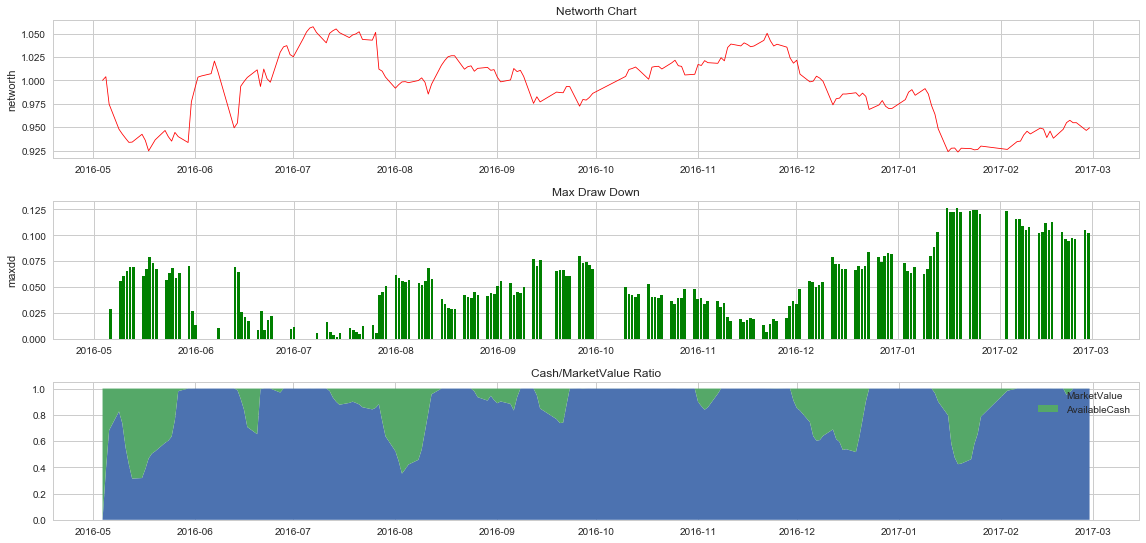

In [13]:
test.showBackTestingResult()